# Kaggle Competition - Housing Prices

## Background

### Goal

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.

### Metric

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### Submission File Format

The file should contain a header and have the following format:

```csv
Id,SalePrice
1461,169000.1
1462,187724.1233
1463,175221
etc.
```

## Dependencies

In [ ]:
# !python --version
# !conda install matplotlib numpy pandas scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization import visualize as vz
%matplotlib inline

from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import fbeta_score, accuracy_score

sns.set()

## Data Exploration

In [2]:
df = pd.read_csv('../data/raw/train.csv', index_col='Id')
saleprice = df['SalePrice']
features_raw = df.drop('SalePrice', axis=1)

# Uncomment this line to save the DataFrame
# features_raw.to_csv('../data/interim/features_raw.csv')

In [3]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.shape

(1460, 80)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Let's look at the distribution of our target variable, Saleprice:

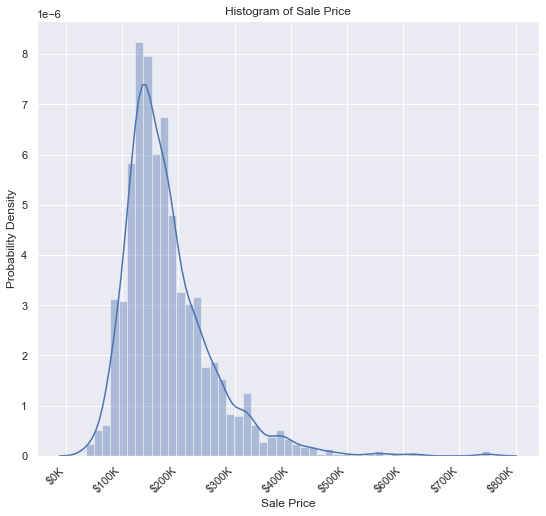

In [7]:
plt.figure(figsize=(9, 8))
ax = sns.distplot(saleprice, axlabel='Sale Price')
ax.set_title('Histogram of Sale Price')
ax.set(xlabel='Sale Price', ylabel='Probability Density')
ax.xaxis.set_major_formatter(vz.currency)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/SalePrice_Distribution.svg')

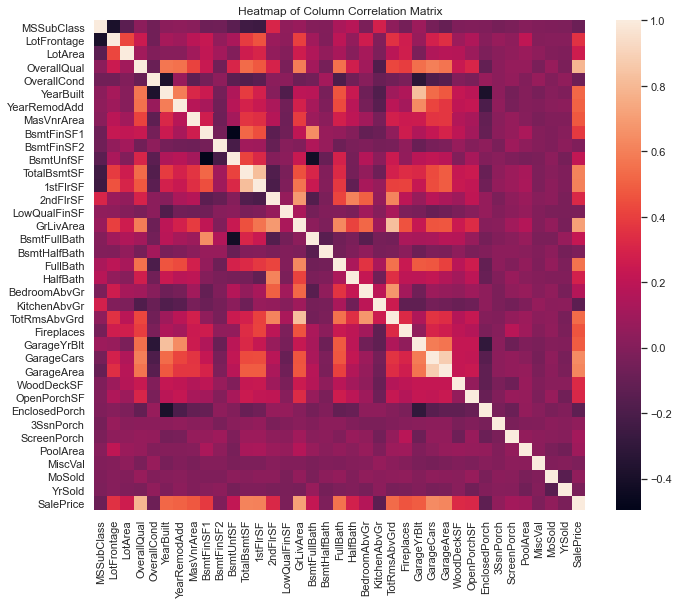

In [8]:
plt.figure(figsize=(11,9))
ax = sns.heatmap(df.corr())
ax.set_title('Heatmap of Column Correlation Matrix')
plt.show()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/Column_Correlation_Heatmap.svg')

In [9]:
df.corr()['SalePrice'].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

From above, there appears to be a strong correlation between 'OverallQual' and 'SalePrice'. Let's explore 'OverallQual' a bit more:

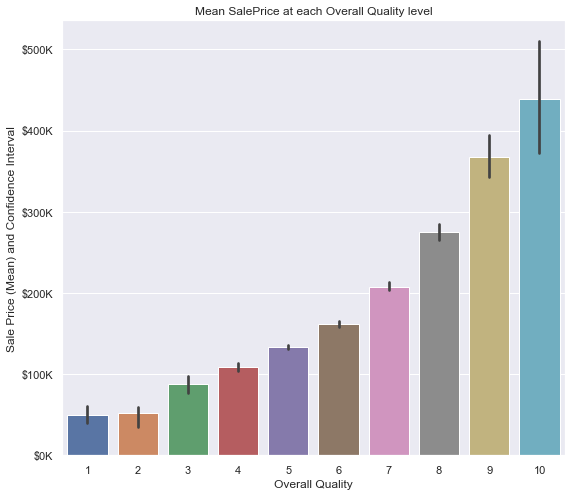

In [10]:
plt.figure(figsize=(9, 8))
ax = sns.barplot(x='OverallQual', y='SalePrice', data=df)
ax.yaxis.set_major_formatter(vz.currency)
ax.set_title('Mean SalePrice at each Overall Quality level')
ax.set(xlabel='Overall Quality', ylabel='Sale Price (Mean) and Confidence Interval')
plt.show()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/Barplot_SalePrice_OverallQual.svg')

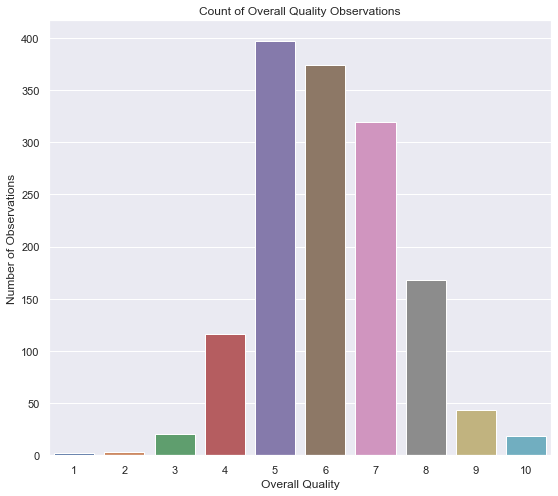

In [11]:
plt.figure(figsize=(9, 8))
ax = sns.countplot(x='OverallQual', data=df)
ax.set_title('Count of Overall Quality Observations')
ax.set(xlabel='Overall Quality', ylabel='Number of Observations')
plt.show()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/Countplot_OverallQual.svg')

<Figure size 648x576 with 0 Axes>

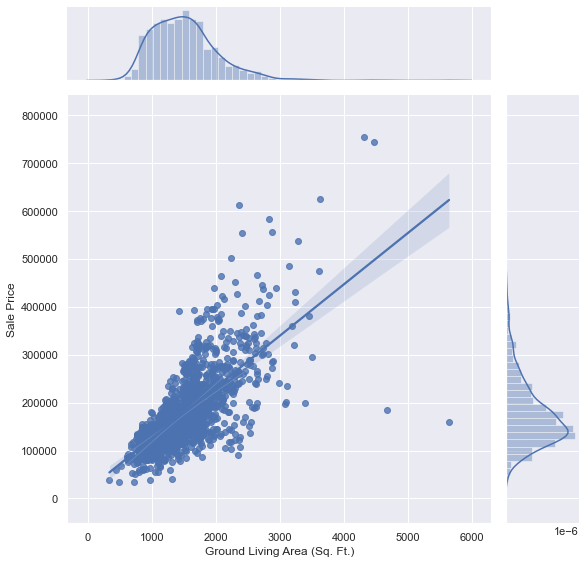

In [12]:
plt.figure(figsize=(9, 8))
sns.jointplot(x='GrLivArea',y='SalePrice',
              kind='reg',
              height=8,
              data=df).set_axis_labels('Ground Living Area (Sq. Ft.)', 'Sale Price')

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/Jointplot_GrLivArea_SalePrice.svg')

In [13]:
# Categorical Features
categorical_cols = features_raw.select_dtypes(include=object).columns
len(categorical_cols)

43

In [14]:
# Numerical Features
numerical_cols = features_raw.select_dtypes(include=np.number).columns
len(numerical_cols)

36

---
## Exploration Summary

- 1460 Rows
- 81 Columns
- Most columns (43) are of type object (non-numeric)
- Goal is to predict 'SalePrice'
- Of the non-categorical features, 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF' have the strongest direct correlation to that of 'SalePrice'
- 19 columns have null values included
- Columns 'PoolQC', 'MiscFeature', 'Alley', 'Fence' are missing > 80% data

Observation of our target variable shows the mass of the distribution concentrated on the left of the figure (Histogram of Sale Price), indicating positive skew. Since we're optimizing for minimal root mean squared error (RMSE), and linear models make various assumptions about the input data, we may need to apply some form of transformation to remove this skewness. Assumptions:

- Linearity: Assumes that the relationship between predictors and target variable is linear
- Weak exogeneity: eg. Predictor variables are assumed to be error-free (no outliers)
- Constant Variance: Different values of the response variable have the same variance in their errors, regardless of the values of the predictor variables
- No collinearity: if you have highly correlated predictors, it’s most likely your model will overfit
- Lack of perfect multicollinearity: Ensure we have no highly-correlated predictors
- Independence of errors: Assumes errors of the response variables are not correlated with each other.
- Normal distribution: more reliable predictions are made if the predictors and the target variable are normally distributed

In [ ]:
# transform_notebook(ipynb_file="1.0-saw-initial-data-exploration.ipynb", export_list=["html", "py"])